# Séries Temporais Previsão

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Funções

### Cálculo de métricas de previsão

In [2]:
# Métricas de previsão
def metricas(previsto, observado):
    erro = previsto - observado                   # erro
    me = np.mean(erro)                            # ME
    mse = np.square(erro).mean()                  # MSE
    rmse = np.sqrt(mse)                           # RMSE
    mae = np.abs(erro).mean()                     # MAE
    mpe = (erro / observado).mean()               # MPE
    mape = np.abs(erro / observado).mean()        # MAPE
    mins = np.amin(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    maxs = np.amax(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)               # MINMAX
    return({'ME':me, 'MSE':mse, 'RMSE':rmse,
            'MAE': mae, 'MPE': mpe, 'MAPE':mape,
            'MIN-MAX':minmax})

## Preparar dados

### Ler dados

Dados de requisição diária aos servidores.

In [3]:
# Ler os dados
serie_requisicoes_dia = pd.read_csv('/content/servidores_requisicoes_dia.csv',
                                    index_col=0, parse_dates=True)

serie_requisicoes_dia.head(3)

,WEB,BD,APLIC
Data,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN


### Definir proporção dos arquivos de treinamento e teste
Definir as proporções dos dados da série temporal que serão usadas para terinamento e teste.
* Proporção usada para teste: 0,3
* Proporção usada para terinamento: 0,7 (1 - proporção usada para teste)

In [4]:
prop_teste = 0.3
prop_teino = 1 - prop_teste

# EXEMPLO - Série de requisições mensais ao servidor WEB

### Selecionar coluna e reformatar para requisições mensais

In [5]:
# Selecionar coluna WEB e reformatar para requisições mensais (soma)
mensal = serie_requisicoes_dia['WEB'].resample('M').sum()
serie_WEB = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
serie_WEB.head(10)

<ipython-input-5-4fa5924758aa>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensal = serie_requisicoes_dia['WEB'].resample('M').sum()


,Valor
Data,
2006-01-31,45304.704
2006-02-28,41078.993
2006-03-31,43978.124
2006-04-30,38251.767
2006-05-31,38858.143
2006-06-30,37253.450
2006-07-31,38852.185
2006-08-31,38476.852
2006-09-30,39335.098


### Plotar série

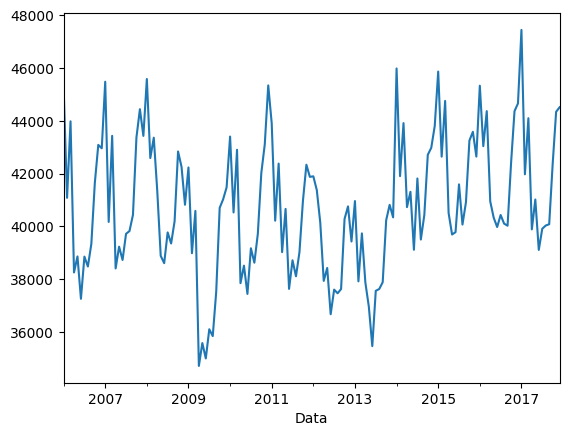

In [6]:
# Plotar WEB
serie_WEB['Valor'].plot();

## Modelo -  Série WEB Baseline
Prever apenas o próximo valor da série usando a última observação

### WEB Baseline - Preparação de Dados

#### Dataframe com coluna de valores observados
* Incluir a coluna Y_real como o próximo valor observado para cada valor inicial observado

In [7]:
# Copiar serie_WEB para o dataframe serie_BD_baseline
serie_WEB_baseline = serie_WEB.copy()

# Calcular os valores de previsão para a serie_WEB_baseline
# Incluir a coluna Y_prev com valores da coluna Valor defasados de 1
# Essa coluna vai conter o próximo valor na série temporal como previsão
serie_WEB_baseline['Y_prev'] = serie_WEB_baseline['Valor'].shift(-1)

# Após essa operação o dataframe serie_WE_baseline conterá duas colunas:
#       Valor (valores da série)
#       Y_prev (previsões: próximo valor)

# Imprimir as cinco primeiras linhas da série_WEB_baseline
print(serie_WEB_baseline.head(5))

                Valor     Y_prev
Data                            
2006-01-31  45304.704  41078.993
2006-02-28  41078.993  43978.124
2006-03-31  43978.124  38251.767
2006-04-30  38251.767  38858.143
2006-05-31  38858.143  37253.450


#### Definir os tamanhos das séries de teste e treinamento

In [8]:
###############################################################################
# A série baseline será dividida em dados de treinamento e teste
# Calcular tamanhos das séries de treinamento e teste
###############################################################################
tam_teste = int(np.ceil(serie_WEB_baseline.shape[0]*prop_teste))
tam_treino = serie_WEB_baseline.shape[0] - tam_teste

#### Dataframe com dados de treinamento
* Selecionar no dataframe baseline a série de treino
* A série de treinamento contém a coluna Valor e a coluna Y_prev renomeadas para X_treino e Y_treino

No modelo baseline não há treinamento. X_treino é usado para plotagem e Y_treino é desnecessário.<br>
O dataframe serie_treino_baseline será construído com as duas variáveis para demonstrar a preparação de dados para outros modelos.

In [9]:
###############################################################################
# Preparar dataframe com dados de treinamento
# Na abordagem baseline não há treinamento
# X_treino é usado para plotagem e Y_treino é desnecessário
# Contrução do dataframe completo para ilustrar o cálculo
################################################################################
# Selecionar a parte inicial do dataframe temporário (até a linha tam_treino)
# Copiar a parte selecionada para o data frame serie_treino_baseline
# É necesário fazer uma cópia para poder manipular a parte selecionada
################################################################################
serie_treino_WEB_baseline = serie_WEB_baseline[:tam_treino]
serie_treino_WEB_baseline = serie_treino_WEB_baseline.copy()
################################################################################
# Renomerar as colunas Valor para X_treino e Y_prev para  Y_treino
# Para renomear é necessário copiar como novo nome e remover
################################################################################
serie_treino_WEB_baseline['X_treino'] = serie_treino_WEB_baseline['Valor']
serie_treino_WEB_baseline['Y_treino'] = serie_treino_WEB_baseline['Y_prev']
serie_treino_WEB_baseline.drop('Valor', inplace=True, axis=1)
serie_treino_WEB_baseline.drop('Y_prev', inplace=True, axis=1)

# Mostar a série de treino
print(serie_treino_WEB_baseline.head(5))

             X_treino   Y_treino
Data                            
2006-01-31  45304.704  41078.993
2006-02-28  41078.993  43978.124
2006-03-31  43978.124  38251.767
2006-04-30  38251.767  38858.143
2006-05-31  38858.143  37253.450


#### Dataframe com os dados de teste
* Selecionar no dataframe baseline a série de teste
* A série de teste contém a coluna Valor e a coluna Y_prev renomeadas para X_teste e Y_teste

In [10]:
###############################################################################
# Preparar dataframe de teste
# X_teste é usado como previsão (a previsão é o último valor observado)
# Y_teste é usado para calcular as métricas
# Contrução do dataframe completo para ilustrar o cálculo
################################################################################
# Selecionar a parte inicial do dataframe temporário (a partir da a linha tam_teste)
# Copiar a parte selecionada para o data frame serie_teste_baseline
# É necesário fazer uma cópia para poder manipular a parte selecionada
################################################################################
serie_teste_WEB_baseline = serie_WEB_baseline[-tam_teste:]
serie_teste_WEB_baseline = serie_teste_WEB_baseline.copy()
################################################################################
# Renomerar as colunas Valor para X_teste e Y_prev para  Y_teste
# Para renomear é necessário copiar como novo nome e remover
################################################################################
serie_teste_WEB_baseline['X_teste'] = serie_teste_WEB_baseline['Valor']
serie_teste_WEB_baseline['Y_teste'] = serie_teste_WEB_baseline['Y_prev']
serie_teste_WEB_baseline.drop('Valor', inplace=True, axis=1)
serie_teste_WEB_baseline.drop('Y_prev', inplace=True, axis=1)

# Mostar a série de teste
print(serie_teste_WEB_baseline.head(5))

              X_teste    Y_teste
Data                            
2014-05-31  41307.212  39111.367
2014-06-30  39111.367  41813.118
2014-07-31  41813.118  39499.300
2014-08-31  39499.300  40429.272
2014-09-30  40429.272  42710.385


#### Incluir dados de previsão no dataframe de teste
* Utiliza a última observação como previsão
* Comumente utilizado como baseline de comparação (modelo mais simples possível de previsão)

In [11]:
# Incluir dados de previsão no dataframe de teste
# O valor da previsão é o valor da medida
serie_teste_WEB_baseline['Y_prev'] = serie_teste_WEB_baseline['X_teste']
# Descarta a última linha porque não há previsão para o último valor
serie_teste_WEB_baseline = serie_teste_WEB_baseline.drop(serie_teste_WEB_baseline.tail(1).index)

# Mostrar cinco promeiras linhas de serie_teste_WEB_baseline
print(serie_teste_WEB_baseline.head(5))

              X_teste    Y_teste     Y_prev
Data                                       
2014-05-31  41307.212  39111.367  41307.212
2014-06-30  39111.367  41813.118  39111.367
2014-07-31  41813.118  39499.300  41813.118
2014-08-31  39499.300  40429.272  39499.300
2014-09-30  40429.272  42710.385  40429.272


#### Plotar gráfico de previsão

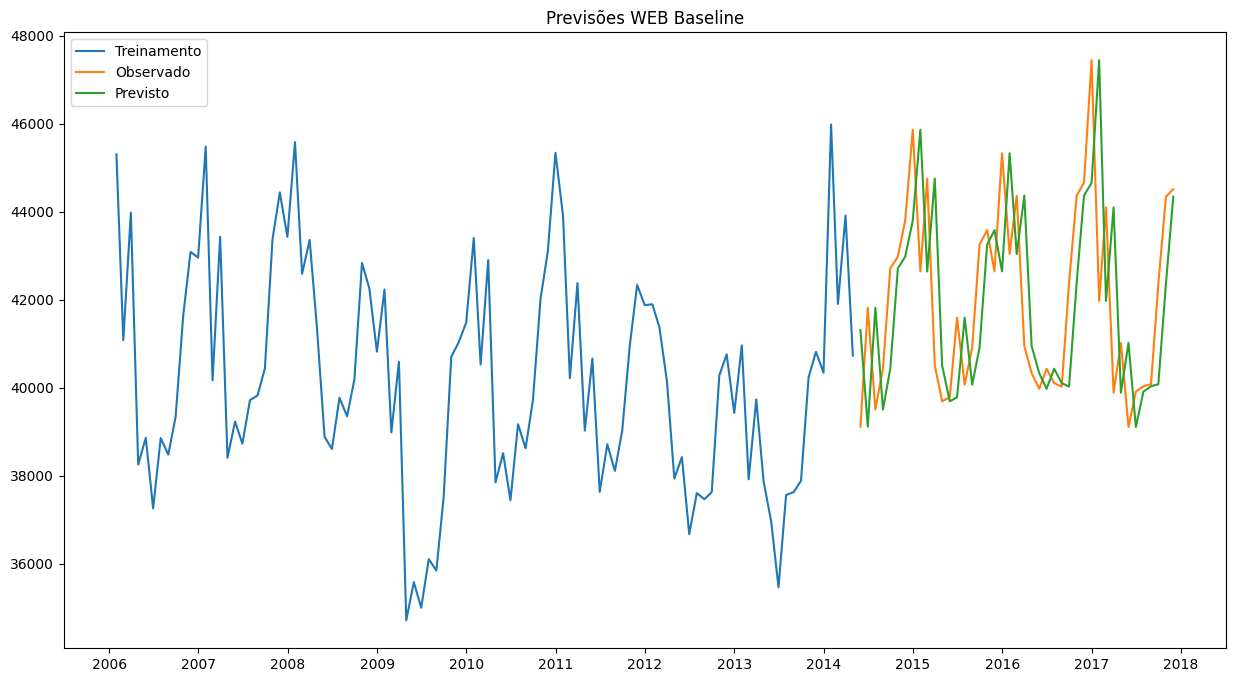

In [12]:
# Plotar gráfico de previsão
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(serie_treino_WEB_baseline['X_treino'], label='Treinamento')
ax.plot(serie_teste_WEB_baseline['Y_teste'], label='Observado')
ax.plot(serie_teste_WEB_baseline['Y_prev'], label='Previsto')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Previsões WEB Baseline');

### WEB Baseline - Desempenho

#### Calcular e imprimir métricas de previsão

In [13]:
# Calcular métricas de previsão
metricas_WEB_baseline = metricas(serie_teste_WEB_baseline['Y_prev'].values,
                       serie_teste_WEB_baseline['Y_teste'].values)

# Imprimir métricas de previsão
METRICAS = []
VALORES_WEB = []
print('Metricas Modelo WEB Baseline')
for metrica in metricas_WEB_baseline:
    print(f'{metrica} = {metricas_WEB_baseline[metrica]}')
    METRICAS.append(metrica)
    VALORES_WEB.append(metricas_WEB_baseline[metrica])

Metricas Modelo WEB Baseline
ME = -74.50912348837215
MSE = 4322895.925686979
RMSE = 2079.15750381903
MAE = 1653.0265188372098
MPE = -0.0005410408011433154
MAPE = 0.03921936796103517
MIN-MAX = 0.03780841945687019


#### Salvar méticas para comparação

In [14]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(WEB_Baseline=VALORES_WEB)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

#### Comparar métricas

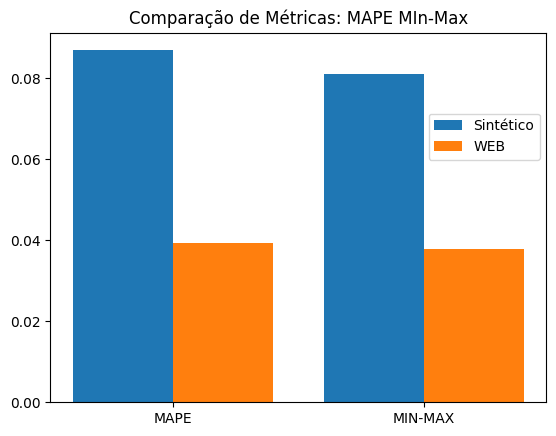

In [15]:
X = ['MAPE', 'MIN-MAX']
mST = []
mWEB = []
for x in X:
    mST.append(dfMetricas['ST_Baseline'].loc[x])
    mWEB.append(dfMetricas['WEB_Baseline'].loc[x])

eixo_X = np.arange(len(X))

plt.bar(eixo_X - 0.2, mST, 0.4, label = 'Sintético')
plt.bar(eixo_X + 0.2, mWEB, 0.4, label = 'WEB')

plt.xticks(eixo_X, X)
plt.title('Comparação de Métricas: MAPE MIn-Max')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show;

# FORMATIVA - Série de requisições mensais ao servidor BD

### Selecionar coluna e reformatar para requisições mensais

In [16]:
# Selecionar coluna BD e reformatar para requisições mensais (soma)
serie_requisicoes_BD_mes = serie_requisicoes_dia['BD'].resample('M').sum()

# Selecionar dados a partir de Janeiro de 2010
mensal = pd.Series(serie_requisicoes_BD_mes.loc['2010-01':'2017-12'], copy=True)

# Formatação com index = data e coluna = Valor
serie_BD = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
tam_serie_BD = serie_BD.shape[0]
print(serie_BD.head(5))
print(serie_BD.tail(5))

               Valor
Data                
2010-01-31  3148.914
2010-02-28  3398.549
2010-03-31  4295.821
2010-04-30  2902.002
2010-05-31  2502.340
                Valor
Data                 
2017-08-31   5499.798
2017-09-30   6287.730
2017-10-31  12480.097
2017-11-30  10259.001
2017-12-31  14725.436


<ipython-input-16-f20ac5be74cc>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie_requisicoes_BD_mes = serie_requisicoes_dia['BD'].resample('M').sum()


### Visualizar requisições mensais ao servidor BD

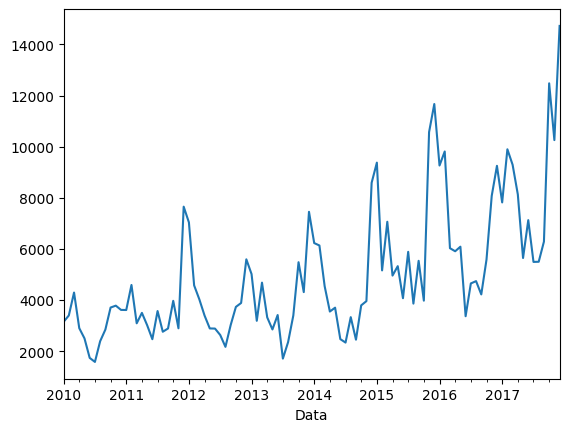

In [17]:
# Plotar série BD
serie_BD['Valor'].plot();

## Modelo -  Série BD Baseline
Prever apenas o próximo valor da série usando a última observação

### BD Baseline - Preparação de Dados

#### Dataframe com coluna de valores observados
* Incluir a coluna Y_real como o próximo valor observado para cada valor inicial observado

In [24]:
# Copiar serie_BD para o dataframe serie_BD_baseline
serie_BD_baseline = serie_BD.copy()

# Calcular os valores de previsão para a serie_BD_baseline
# Incluir a coluna Y_prev com valores da coluna Valor defasados de 1
# Essa coluna vai conter o próximo valor na série temporal
#################################################
###### Colocar seu código aqui ##################
#### Dica: ver comando na análise da série WEB ##
#################################################

serie_BD_baseline['Y_prev'] = serie_BD_baseline['Valor'].shift(-1)

# Após essa operação o dataframe serie_BD_baseline conterá duas colunas:
#       Valor (valores da série)
#       Y_prev (valor defasado de 1)

# Imprimir as cinco promeiras linhas da série_BD_baseline
# Dica: se o seu código estiver correto você deve obter os segintes valores
# 2010-01-31  3148.914  3398.549
# 2010-02-28  3398.549  4295.821
# 2010-03-31  4295.821  2902.002
# 2010-04-30  2902.002  2502.340
# 2010-05-31  2502.340  1738.655
print(serie_BD_baseline.head(5))

               Valor    Y_prev
Data                          
2010-01-31  3148.914  3398.549
2010-02-28  3398.549  4295.821
2010-03-31  4295.821  2902.002
2010-04-30  2902.002  2502.340
2010-05-31  2502.340  1738.655


#### Definir os tamanhos das séries de teste e treinamento





In [25]:


# Definir proporção dos arquivos de treinamento e teste
prop_teste = 0.3  # Proporção para teste
prop_treino = 1 - prop_teste  # Proporção para treinamento

# Calcular tamanhos das séries de treinamento e teste
tam_teste = int(np.ceil(serie_BD_baseline.shape[0] * prop_teste))
tam_treino = serie_BD_baseline.shape[0] - tam_teste

# Preparar dataframe com dados de treinamento
# Selecionar no dataframe baseline a série de treino
serie_treino_BD_baseline = serie_BD_baseline[:tam_treino].copy()
serie_treino_BD_baseline['X_treino'] = serie_treino_BD_baseline['Valor']
serie_treino_BD_baseline['Y_treino'] = serie_treino_BD_baseline['Y_prev']
serie_treino_BD_baseline.drop(['Valor', 'Y_prev'], inplace=True, axis=1)

# Mostrar a série de treino
print(serie_treino_BD_baseline.head(5))

# Preparar dataframe de teste
# Selecionar no dataframe baseline a série de teste
serie_teste_BD_baseline = serie_BD_baseline[-tam_teste:].copy()
serie_teste_BD_baseline['X_teste'] = serie_teste_BD_baseline['Valor']
serie_teste_BD_baseline['Y_teste'] = serie_teste_BD_baseline['Y_prev']
serie_teste_BD_baseline.drop(['Valor', 'Y_prev'], inplace=True, axis=1)

# Mostrar a série de teste
print(serie_teste_BD_baseline.head(5))


            X_treino  Y_treino
Data                          
2010-01-31  3148.914  3398.549
2010-02-28  3398.549  4295.821
2010-03-31  4295.821  2902.002
2010-04-30  2902.002  2502.340
2010-05-31  2502.340  1738.655
              X_teste    Y_teste
Data                            
2015-08-31   3862.851   5536.834
2015-09-30   5536.834   3977.859
2015-10-31   3977.859  10569.828
2015-11-30  10569.828  11670.036
2015-12-31  11670.036   9264.588


#### Dataframe com dados de treinamento
* Selecionar no dataframe baseline a série de treino
* A série de treinamento contém a coluna Valor e a coluna Y_prev renomeadas para X_treino e Y_treino

In [26]:
# Preparar dataframe de treinamento
################################################################################
# Selecionar a parte inicial do dataframe temporário (até a linha tam_treino)
# Copiar a parte selecionada para o data frame serie_treino_BD_baseline
serie_treino_BD_baseline = serie_BD_baseline[:tam_treino].copy()

################################################################################
# Renomear as colunas Valor para X_treino e Y_prev para Y_treino
serie_treino_BD_baseline['X_treino'] = serie_treino_BD_baseline['Valor']
serie_treino_BD_baseline['Y_treino'] = serie_treino_BD_baseline['Y_prev']

# Remover as colunas Valor e Y_prev
serie_treino_BD_baseline.drop(['Valor', 'Y_prev'], inplace=True, axis=1)

# Imprimir as cinco primeiras linhas da serie_treino_BD_baseline
print(serie_treino_BD_baseline.head(5))

            X_treino  Y_treino
Data                          
2010-01-31  3148.914  3398.549
2010-02-28  3398.549  4295.821
2010-03-31  4295.821  2902.002
2010-04-30  2902.002  2502.340
2010-05-31  2502.340  1738.655


#### Dataframe com os dados de teste
* Selecionar no dataframe baseline a série de teste
* A série de teste contém a coluna Valor e a coluna Y_prev renomeadas para X_teste e Y_teste}

In [27]:
# Preparar dataframe de teste
################################################################################
# Selecionar a parte inicial da serie_BD_baseline (a partir da a linha tam_teste)
# Copiar a parte selecionada para o data frame serie_teste_BD_baseline
serie_teste_BD_baseline = serie_BD_baseline[-tam_teste:].copy()

################################################################################
# Renomear as colunas Valor para X_teste e Y_prev para Y_teste
serie_teste_BD_baseline['X_teste'] = serie_teste_BD_baseline['Valor']
serie_teste_BD_baseline['Y_teste'] = serie_teste_BD_baseline['Y_prev']

# Remover as colunas Valor e Y_prev
serie_teste_BD_baseline.drop(['Valor', 'Y_prev'], inplace=True, axis=1)

# Imprimir as cinco primeiras linhas da serie_teste_BD_baseline
print(serie_teste_BD_baseline.head(5))


              X_teste    Y_teste
Data                            
2015-08-31   3862.851   5536.834
2015-09-30   5536.834   3977.859
2015-10-31   3977.859  10569.828
2015-11-30  10569.828  11670.036
2015-12-31  11670.036   9264.588


#### Incluir dados de previsão no dataframe de teste
* Utiliza a última observação como previsão
* Comumente utilizado como baseline de comparação (modelo mais simples possível de previsão)

In [28]:
# Incluir dados de previsão no dataframe de teste
# O valor da previsão é o valor da medida
serie_teste_BD_baseline['Y_prev'] = serie_teste_BD_baseline['X_teste']

# Descartar a última linha porque não há previsão para o último valor
serie_teste_BD_baseline = serie_teste_BD_baseline.drop(serie_teste_BD_baseline.tail(1).index)

# Imprimir cinco últimas linhas da serie_teste_BD_baseline
print(serie_teste_BD_baseline.tail(5))


              X_teste    Y_teste     Y_prev
Data                                       
2017-07-31   5493.524   5499.798   5493.524
2017-08-31   5499.798   6287.730   5499.798
2017-09-30   6287.730  12480.097   6287.730
2017-10-31  12480.097  10259.001  12480.097
2017-11-30  10259.001  14725.436  10259.001


#### Plotar gráfico de previsão

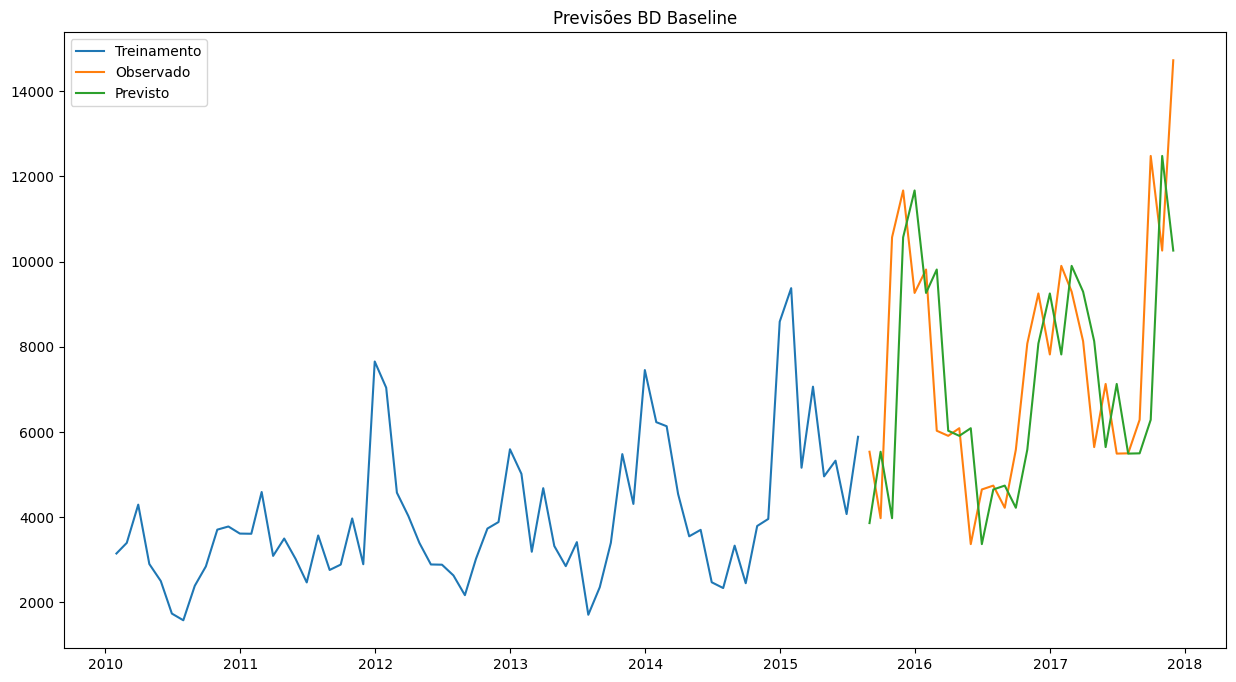

In [29]:
# Plotar gráfico de previsão
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(serie_treino_BD_baseline['X_treino'], label='Treinamento')
ax.plot(serie_teste_BD_baseline['Y_teste'], label='Observado')
ax.plot(serie_teste_BD_baseline['Y_prev'], label='Previsto')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Previsões BD Baseline');

### BD Baseline - Desempenho

#### Calcular e imprimir métricas de previsão

In [30]:
# Calcular métricas de previsão
metricas_BD_baseline = metricas(serie_teste_BD_baseline['Y_prev'].values,
                       serie_teste_BD_baseline['Y_teste'].values)

# Imprimir métricas de previsão
METRICAS = []
VALORES_BD = []
print('Metricas Modelo BD Baseline')
for metrica in metricas_BD_baseline:
    print(f'{metrica} = {metricas_BD_baseline[metrica]}')
    METRICAS.append(metrica)
    VALORES_BD.append(metricas_BD_baseline[metrica])

# Se seu código estiver correto você deve obter os seguintes valores
# ME = -387.9494642857142
# MSE = 6146473.63160332
# RMSE = 2479.208267089177
# MAE = 1862.8577500000004
# MPE = 0.0054064800468577034
# MAPE = 0.24996724603030904
# MIN-MAX = 0.21168440576908476

Metricas Modelo BD Baseline
ME = -387.94946428571427
MSE = 6146473.631603321
RMSE = 2479.2082670891773
MAE = 1862.85775
MPE = 0.005406480046857713
MAPE = 0.24996724603030904
MIN-MAX = 0.21168440576908476



#### Salvar méticas para comparação

In [31]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(BD_Baseline=VALORES_BD)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

#### Comparar métricas

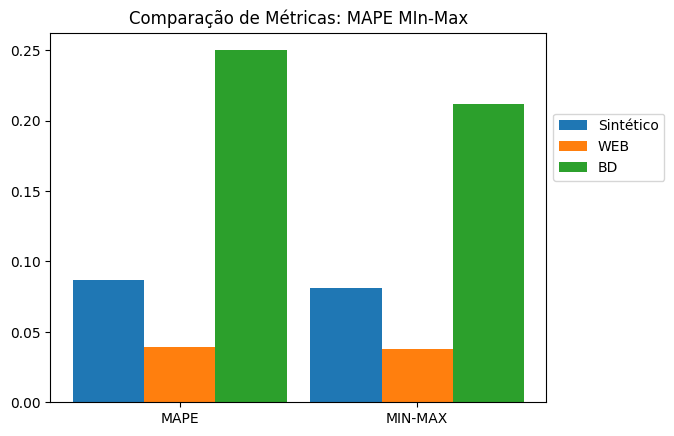

In [32]:
X = ['MAPE', 'MIN-MAX']
mST = []
mWEB = []
mBD = []
for x in X:
    mST.append(dfMetricas['ST_Baseline'].loc[x])
    mWEB.append(dfMetricas['WEB_Baseline'].loc[x])
    mBD.append(dfMetricas['BD_Baseline'].loc[x])

eixo_X = np.arange(len(X))

plt.bar(eixo_X - 0.3, mST, 0.3, label = 'Sintético')
plt.bar(eixo_X, mWEB, 0.3, label = 'WEB')
plt.bar(eixo_X + 0.3, mBD, 0.3, label = 'BD')

plt.xticks(eixo_X, X)
plt.title('Comparação de Métricas: MAPE MIn-Max')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show;